# Create a mock DESI spectrum using a CoLoRe skewer

#### This will require you to install desihub modules and igmhub/LyaMockP1D

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

### Get skewers from CoLoRe

In [3]:
# open data file (test file with few quasars)
hdulist = fits.open('../example_data/raw_colore/N1000_out_srcs_s0_15.fits')
# get information about quasars (TYPE,RA,DEC,Z_COSMO,DZ_RSD)
catalog = hdulist[1].data
z_catalog = catalog['Z_COSMO']
# identify quasars with highest redshift, and get its delta and velocity
id = np.argmax(z_catalog)
z_qso=np.array([z_catalog[id]])
# get deltas (fluctuation around mean density) and line of sight velocity (actually, dz)
delta = hdulist[2].data[id]
velocity = hdulist[3].data[id]
# get arraw with redshift in each cell of grid
z = hdulist[4].data['Z']
Nz=len(z)

### Generate quasar continua from desisim

We need help here! 
We would like qso.make_templates() to take the redshifts from the quasars in CoLoRe,
and then assign a random magnitude (following a QLF). Not sure how to do it...

In [4]:
from desisim import templates as dst
qso = dst.QSO()
continuum_flux, continuum_wave, metadata = qso.make_templates(nmodel=1,seed=123,redshift=z_qso,lyaforest=False)

(4500, 7000)

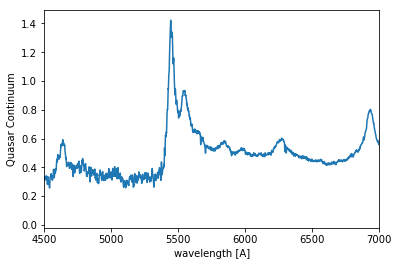

In [5]:
plt.plot(continuum_wave,continuum_flux[0])
plt.xlabel('wavelength [A]')
plt.ylabel('Quasar Continuum')
plt.xlim(4500,7000)

### Transform CoLoRe skewer to flux

In [6]:
#import lya_mock_functions as mock
density = 1+delta
tau = 0.374*pow((1+z)/4.0,5.10)*density**1.6
flux = np.exp(-tau)

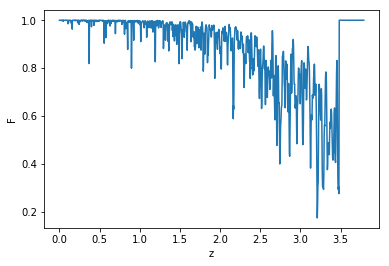

In [7]:
# only add absorption in the forest 
no_forest = (z > z_qso[0])
flux[no_forest]=1.0
# plot flux vs redshift
plt.xlabel('z')
plt.ylabel('F')
plt.plot(z,flux)

### Combine quasar continuum with flux skewer

In [8]:
# will need to interpolate to pixels in quasar continuum
from scipy import interpolate
flux_interp = interpolate.interp1d(1215.67*(1+z),flux)
# will multiply this to quasar continuum
F = np.ones_like(continuum_wave)
in_skewer=(continuum_wave < 1215.67*(1+z_qso[0]))
F[in_skewer] = flux_interp(continuum_wave[in_skewer])

(4500, 6000)

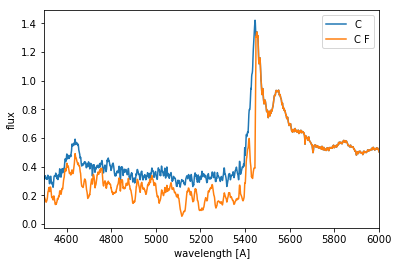

In [9]:
# plot flux vs redshift
plt.xlabel('wavelength [A]')
plt.ylabel('flux')
#plt.plot(continuum_wave,F,label='F')
plt.plot(continuum_wave,continuum_flux[0],label='C')
plt.plot(continuum_wave,F*continuum_flux[0],label='C F')
plt.legend()
plt.xlim(4500,6000)